In [1]:
import math
import numpy as np
import xarray as xr
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
drym = 98288.0 # average dry mass of atmosphere, includes mass above model top [Pa]
P0 = 100000.0 # reference pressure [Pa]
hyai_0 = 0.00225523952394724
tom = hyai_0 * P0 # pressure at top of model
g = 9.80616 # [m/s2]
model_mass_avg = (drym - tom) / g # [kg/m2]
print(model_mass_avg)

10000.089336458437


In [3]:
rearth = 6.37122e6 # [m2]
surf_area = 4.0 * math.pi * rearth ** 2
mwdair = 28.966
kg_to_g = 1.0e3
moles_dair = surf_area * kg_to_g * model_mass_avg / mwdair
mwc = 12.0
vmr_to_PgC = moles_dair * mwc * 1.0e-15
print(vmr_to_PgC)

2113253.840174624


In [4]:
data_catalog.set_catalog('experiments')
varnames = ['SFCO2_LND', 'SFCO2_OCN']
experiment = '1pctCO2'
ds_1pctCO2 = tseries_mod.tseries_get_vars(varnames, 'atm', experiment)
ds_1pctCO2_ann = esmlab_wrap.compute_ann_mean(ds_1pctCO2)

active catalog: experiments


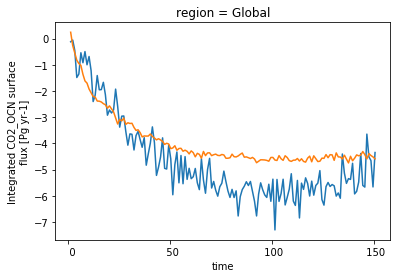

In [5]:
ds_1pctCO2_ann['SFCO2_LND'].plot();
ds_1pctCO2_ann['SFCO2_OCN'].plot();

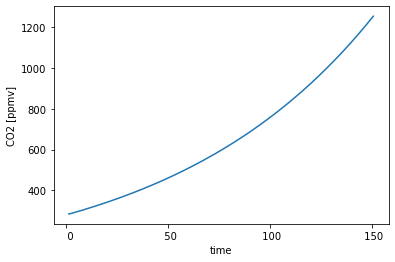

In [6]:
# compute change in atmosphere C mass
# co2vmr values are actually end of month instantaneous values
co2vmr_vals = ds_1pctCO2.co2vmr.values
co2vmr_val0 = 284.7e-6 # value used in piControl
co2vmr_edge_vals = np.insert(co2vmr_vals[11::12], 0, co2vmr_val0)
delta_co2_vmr = np.ediff1d(co2vmr_edge_vals)
ds_1pctCO2_ann['CO2'] = xr.DataArray(1.0e6*(co2vmr_edge_vals[:-1]+0.5*delta_co2_vmr),
                                     dims=('time'), attrs={'units':'ppmv'})
ds_1pctCO2_ann['CO2'].plot();

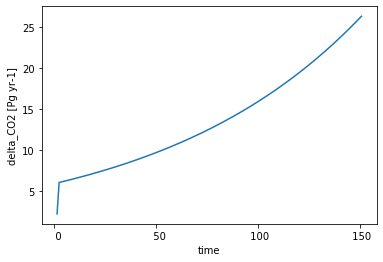

In [7]:
delta_co2_PgC = vmr_to_PgC * delta_co2_vmr
ds_1pctCO2_ann['delta_CO2'] = xr.DataArray(delta_co2_PgC, dims=('time'), attrs={'units':'Pg yr-1'})
ds_1pctCO2_ann['delta_CO2'].plot();

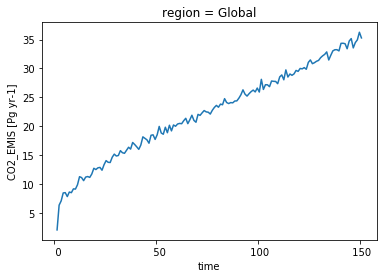

In [8]:
# compute compatible emissions
ds_1pctCO2_ann['CO2_EMIS'] = ds_1pctCO2_ann['delta_CO2'] - ds_1pctCO2_ann['SFCO2_LND'] - ds_1pctCO2_ann['SFCO2_OCN']
ds_1pctCO2_ann['CO2_EMIS'].plot();

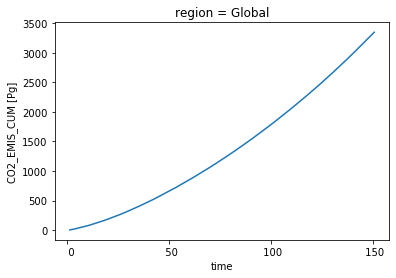

In [9]:
# compute cumulative compatible emissions
da = ds_1pctCO2_ann['CO2_EMIS'].cumsum(dim='time')
da.attrs['units'] = 'Pg'
ds_1pctCO2_ann['CO2_EMIS_CUM'] = da
ds_1pctCO2_ann['CO2_EMIS_CUM'].plot();

In [10]:
# find when cumulative emissions are 1000
mismatch = np.fabs(ds_1pctCO2_ann['CO2_EMIS_CUM'] - 1000)
min_mismatch = mismatch.where(mismatch == mismatch.min(), drop=True)
init_year = min_mismatch.time.values[0].year + 1
init_year

68

In [11]:
ds_1pctCO2_ann['CO2_EMIS_CUM'][65:68]

<xarray.DataArray 'CO2_EMIS_CUM' (time: 3, region: 1)>
array([[ 985.395358],
       [1007.30285 ],
       [1028.317952]])
Coordinates:
  * time     (time) object 0066-07-01 17:00:00 ... 0068-07-01 17:00:00
  * region   (region) object 'Global'
Attributes:
    units:    Pg

In [12]:
1e6*ds_1pctCO2.co2vmr.sel(time=slice('0067-12-01', '0068-01-01'))

<xarray.DataArray 'co2vmr' (time: 1)>
array([551.043051])
Coordinates:
  * time     (time) object 0067-12-16 12:00:00
Attributes:
    long_name:  co2 volume mixing ratio